In [85]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [86]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2024-12-16 12:03:39.181288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734350619.200644   60991 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734350619.206746   60991 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [87]:
import monai
print(dir(monai.networks.nets))
print(monai.__version__)

['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [88]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [120]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")
training_dir_noise = os.path.join(root_dir, "masks_training_noise")
testing_dir_noise = os.path.join(root_dir, "masks_testing_noise")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"
assert os.path.exists(training_dir_noise), f"El directorio {training_dir_noise} no existe"
assert os.path.exists(testing_dir_noise), f"El directorio {testing_dir_noise} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)
training_files_noise = list_nifti_files(training_dir_noise)
testing_files_noise = list_nifti_files(testing_dir_noise)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_noise}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_dir_noise}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing
Se encontraron 200 archivos en ['/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/d

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


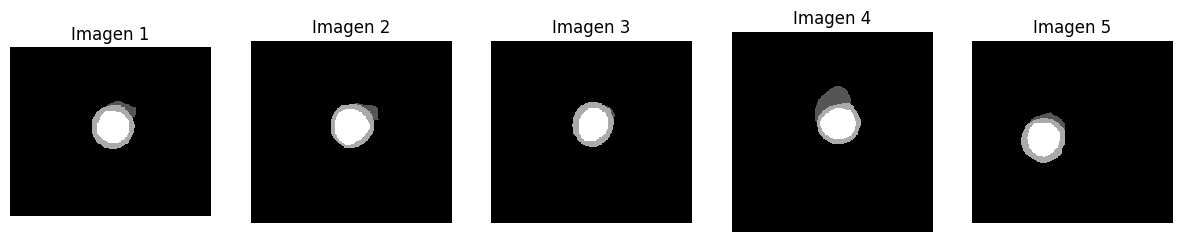

In [121]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


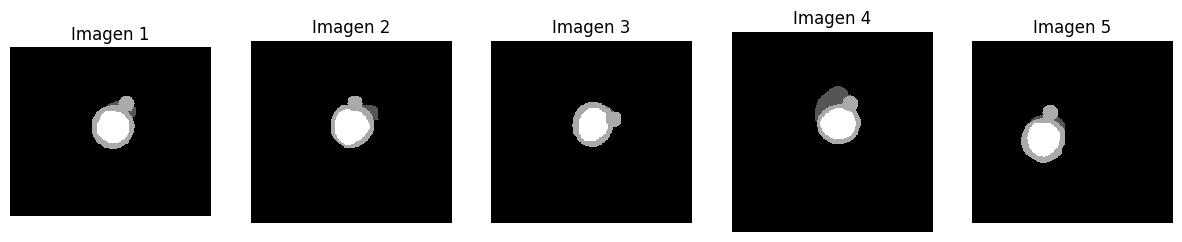

In [122]:
images_noise = [nib.load(file).get_fdata() for file in training_files_noise[:5]] 
fig, axs = plt.subplots(1, len(images_noise), figsize=(15, 5))

for i, img in enumerate(images_noise):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [123]:
all_files = training_files + testing_files
all_files_noise = training_files_noise + testing_files_noise

images = [nib.load(file).get_fdata() for file in all_files]
images_noise = [nib.load(file).get_fdata() for file in all_files_noise]
image_shapes = [img.shape for img in images]
image_shapes_noise = [img.shape for img in images_noise]
print(image_shapes)
print(image_shapes_noise)
average_shape = np.mean(image_shapes, axis=0).astype(int)
average_shape_noise = np.mean(image_shapes_noise, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
print(f"Tamaño promedio de las imágenes con ruido: {average_shape_noise}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)
min_shape_noise = np.min(image_shapes_noise, axis=0)
max_shape_noise = np.max(image_shapes_noise, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")
print(f"Tamaño mínimo: {min_shape_noise}")
print(f"Tamaño máximo: {max_shape_noise}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [124]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [125]:
from monai.data import NibabelReader
from monai.transforms import CastToTyped

In [126]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y escala la intensidad de la imagen

resize_dim = (12, 128, 128)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
    transforms.Resized(keys=["image"], spatial_size=resize_dim, mode=('nearest-exact')), 
]

In [127]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [128]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

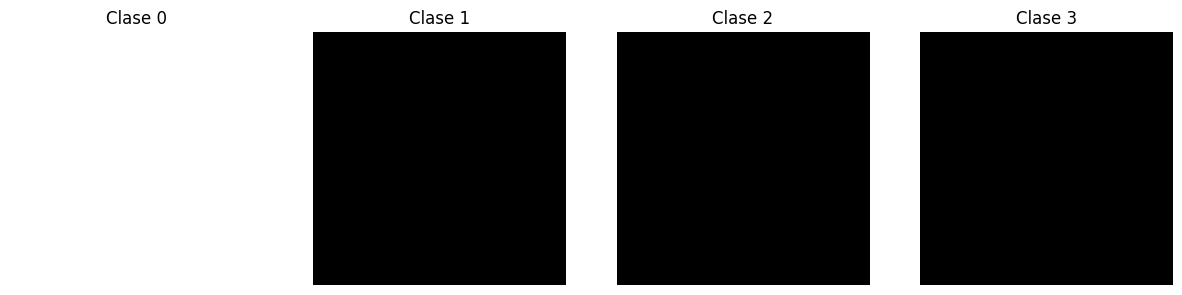

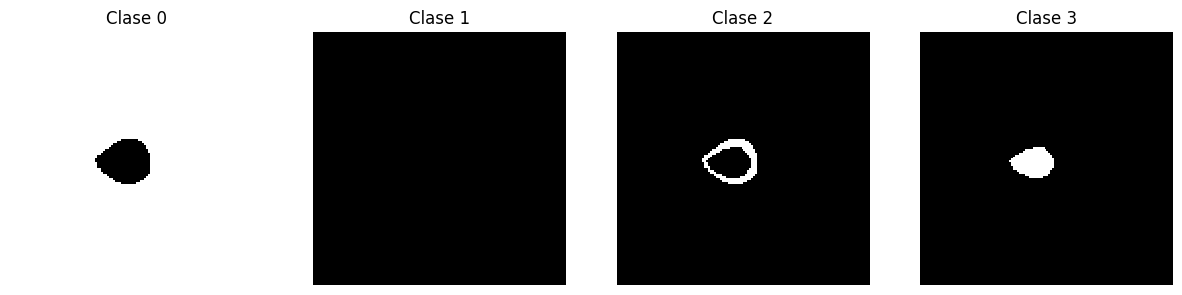

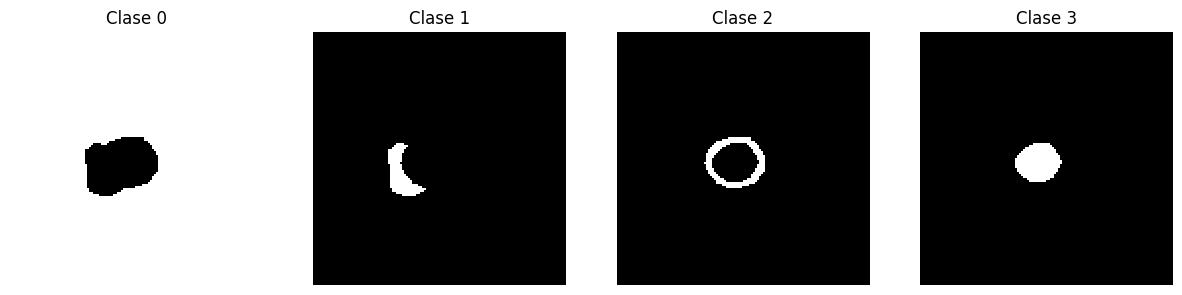

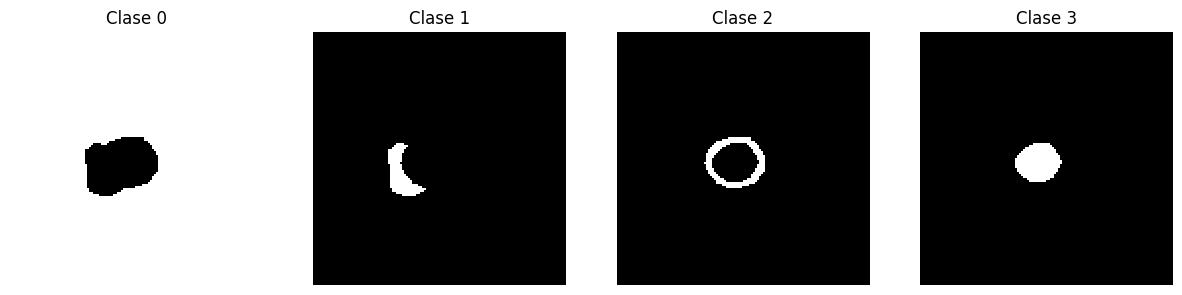

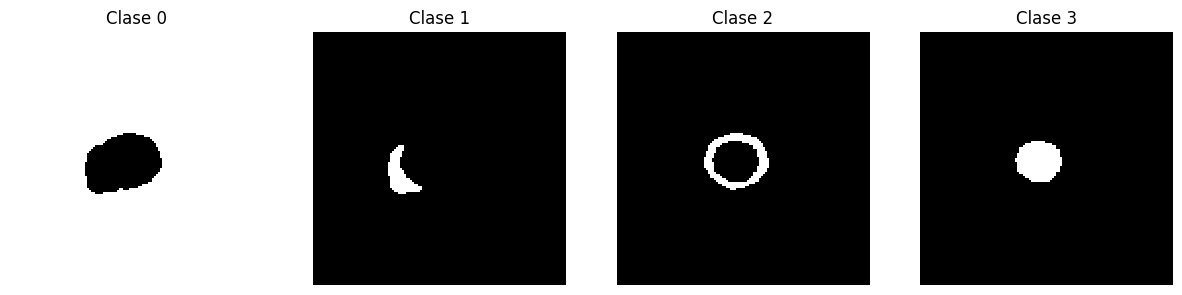

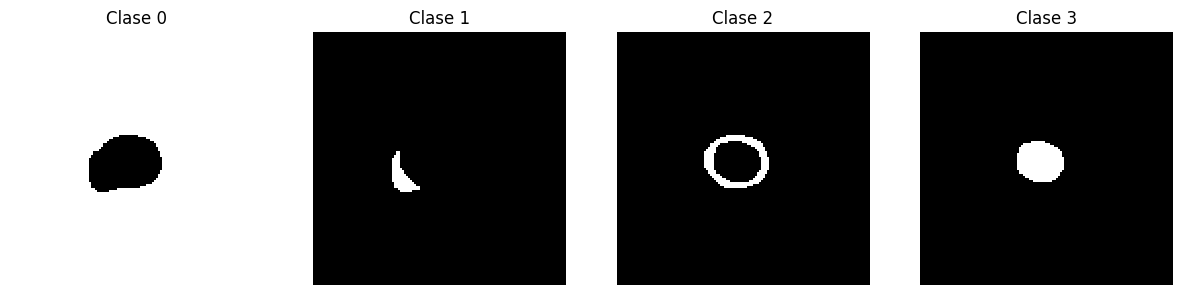

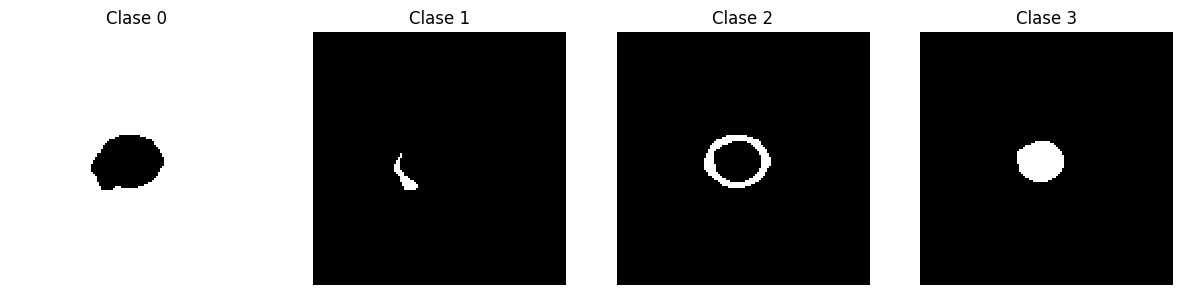

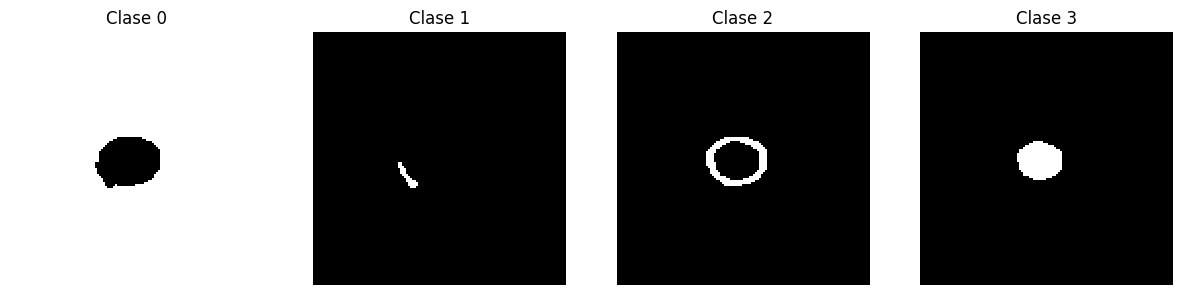

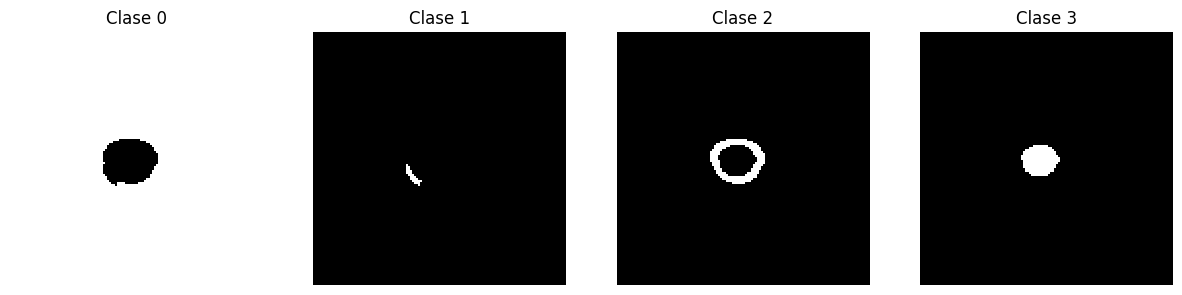

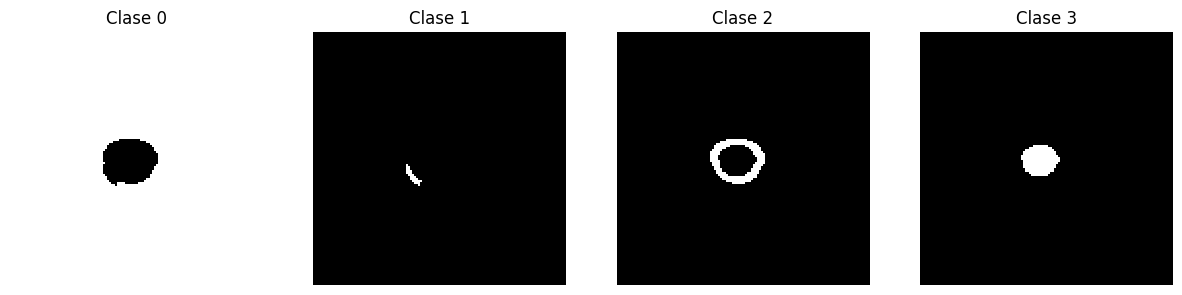

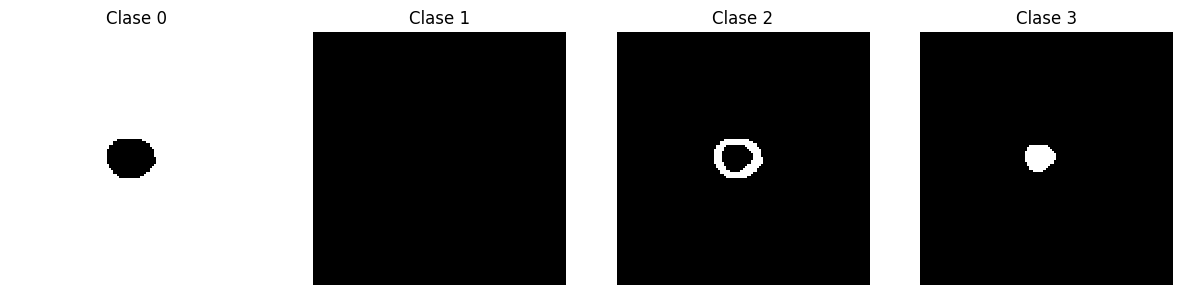

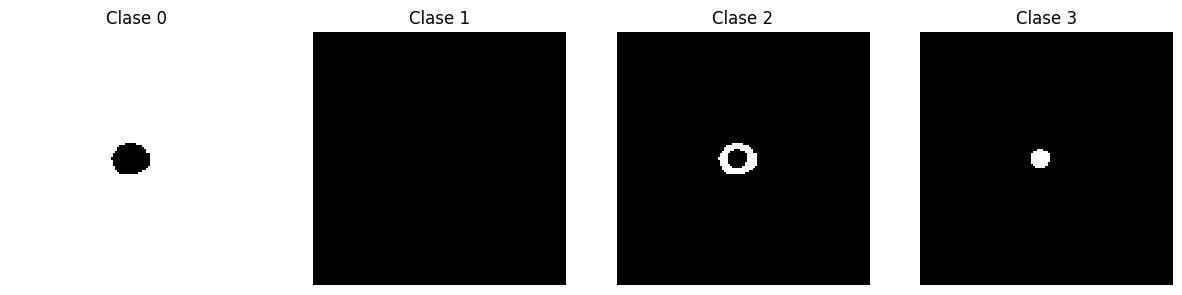

In [129]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

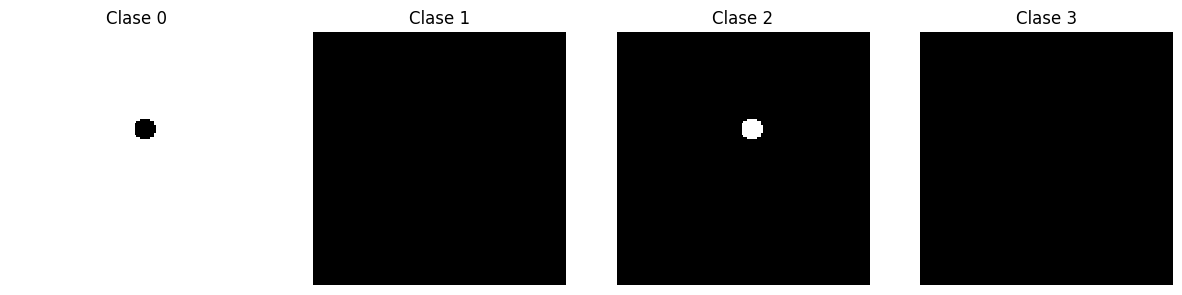

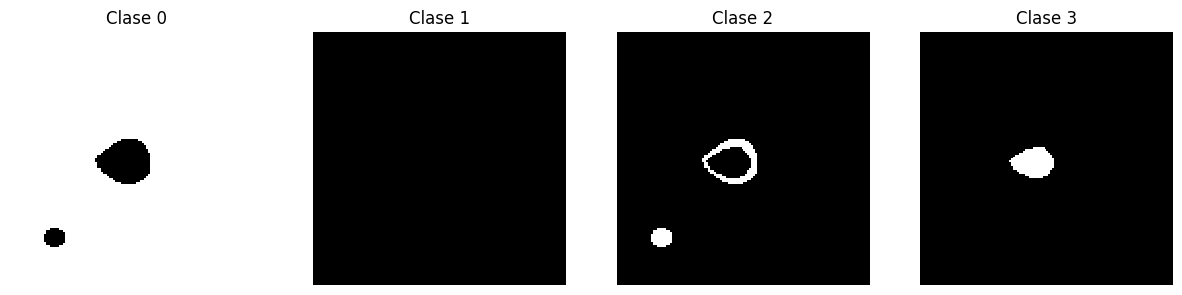

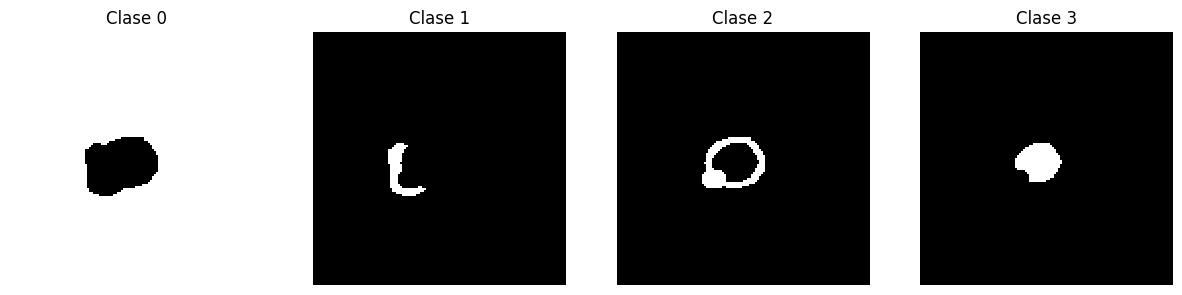

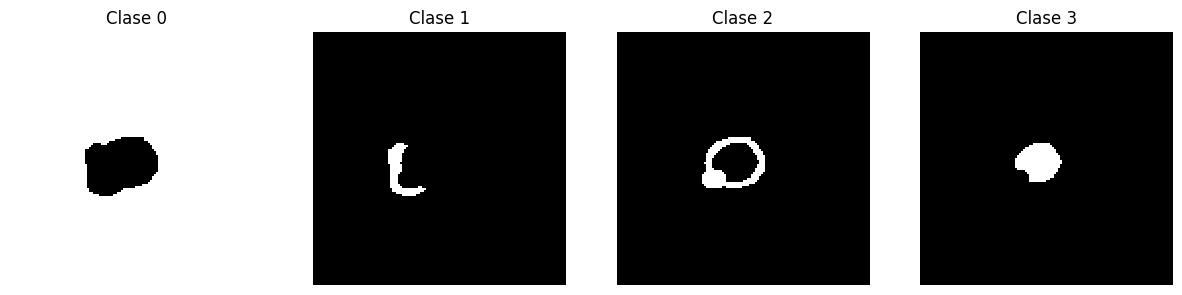

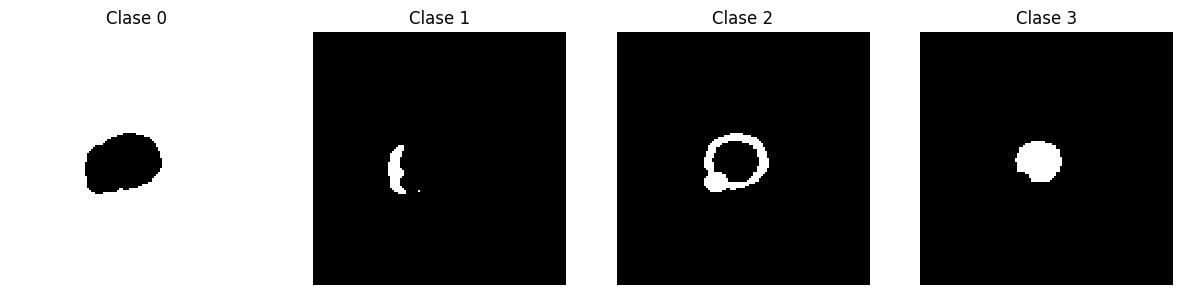

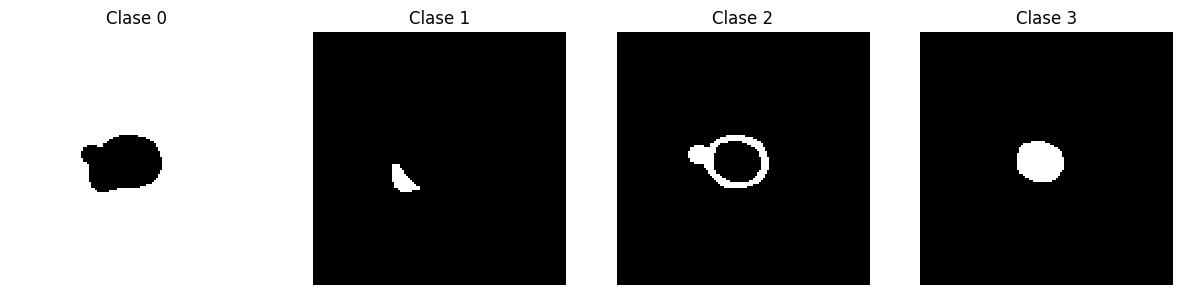

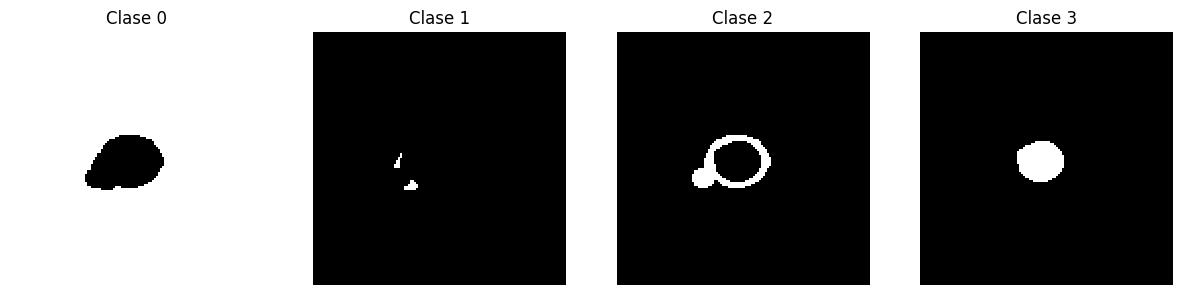

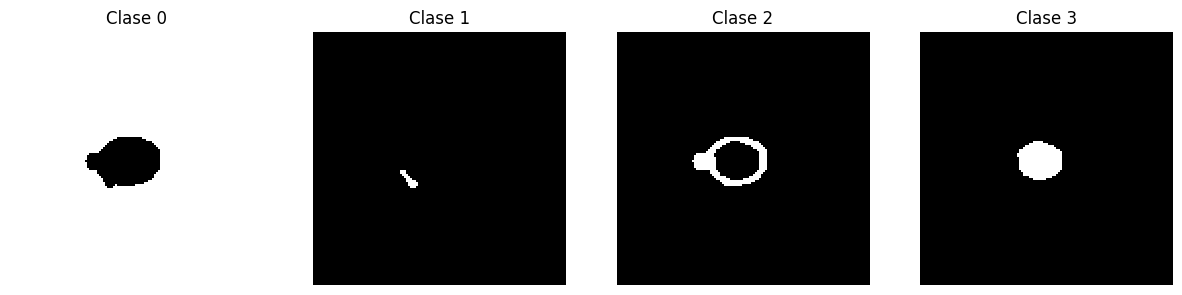

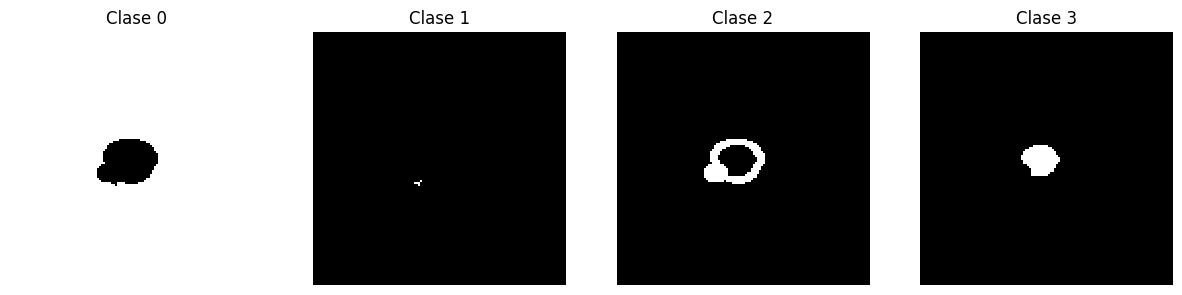

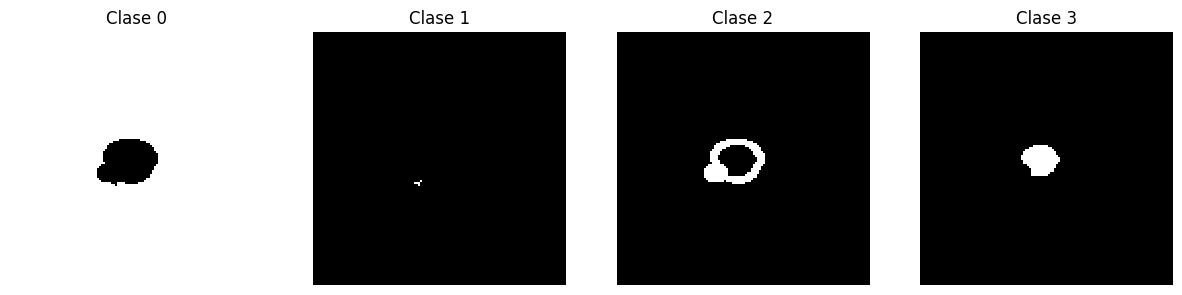

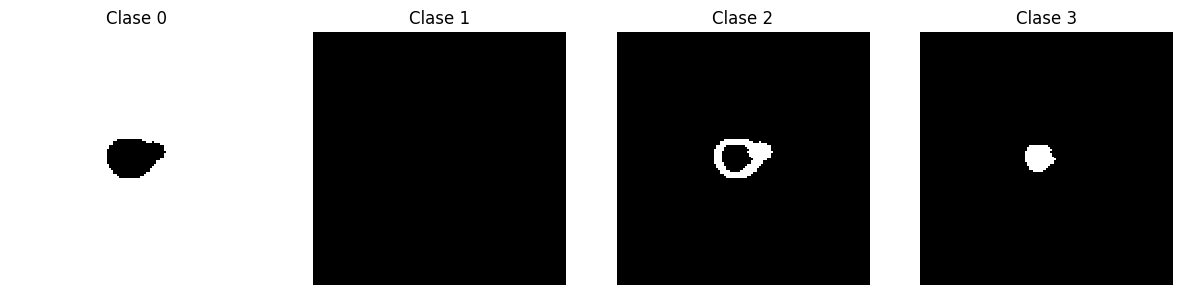

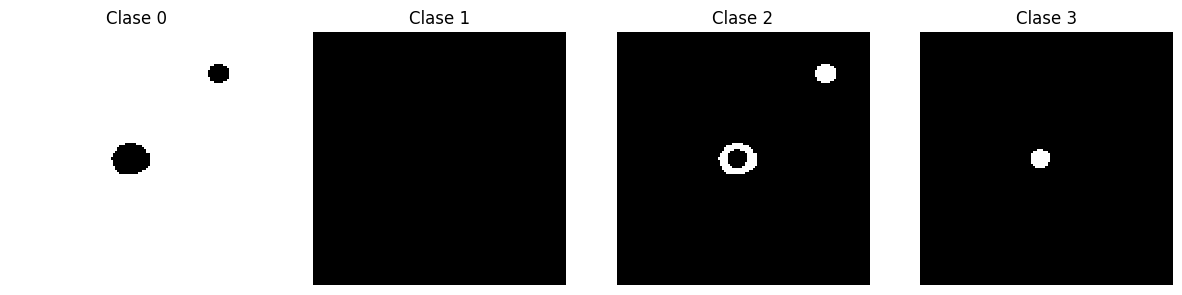

In [130]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_noise)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [131]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [132]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise]
train_ds_noise = Dataset(data=train_data_dicts_noise, transform=all_transforms)

val_data_dicts_noise = [{"image": file} for file in testing_files_noise]
val_ds_noise = Dataset(data=val_data_dicts_noise, transform=all_transforms)

train_loader_noise = DataLoader(train_ds_noise, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_noise[0]["image"].shape}')
val_loader_noise = DataLoader(val_ds_noise, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_noise[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [133]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape
first(val_loader_noise).__getitem__("image").shape

torch.Size([1, 4, 12, 128, 128])

In [134]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [135]:
postprocess_mask_noise = postprocess_transform(val_ds_noise[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_noise.shape[0]):
    plt.subplot(1, postprocess_mask_noise.shape[1], i + 1)
    plt.imshow(postprocess_mask_noise[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


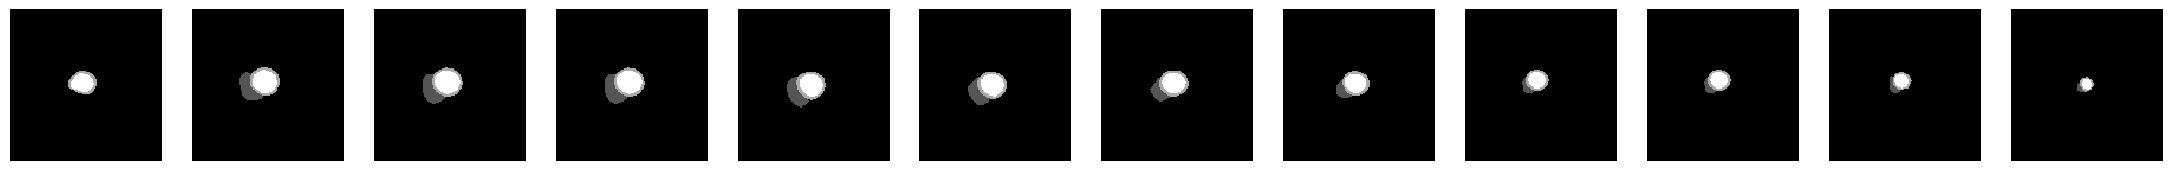

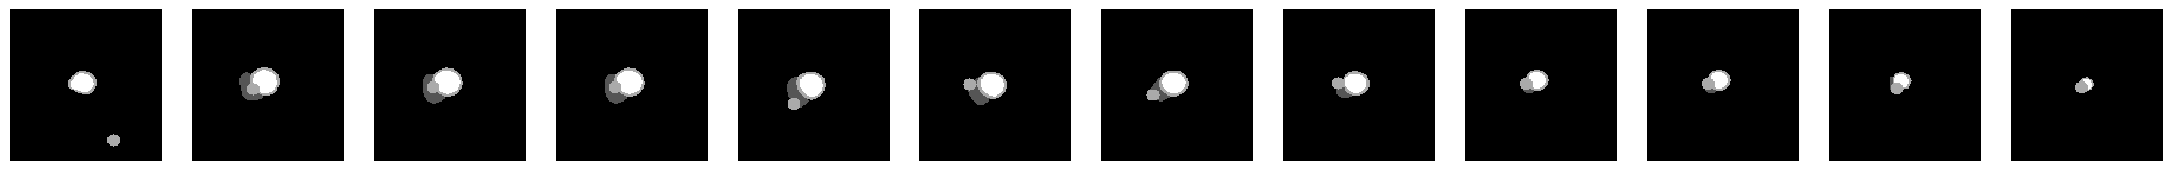

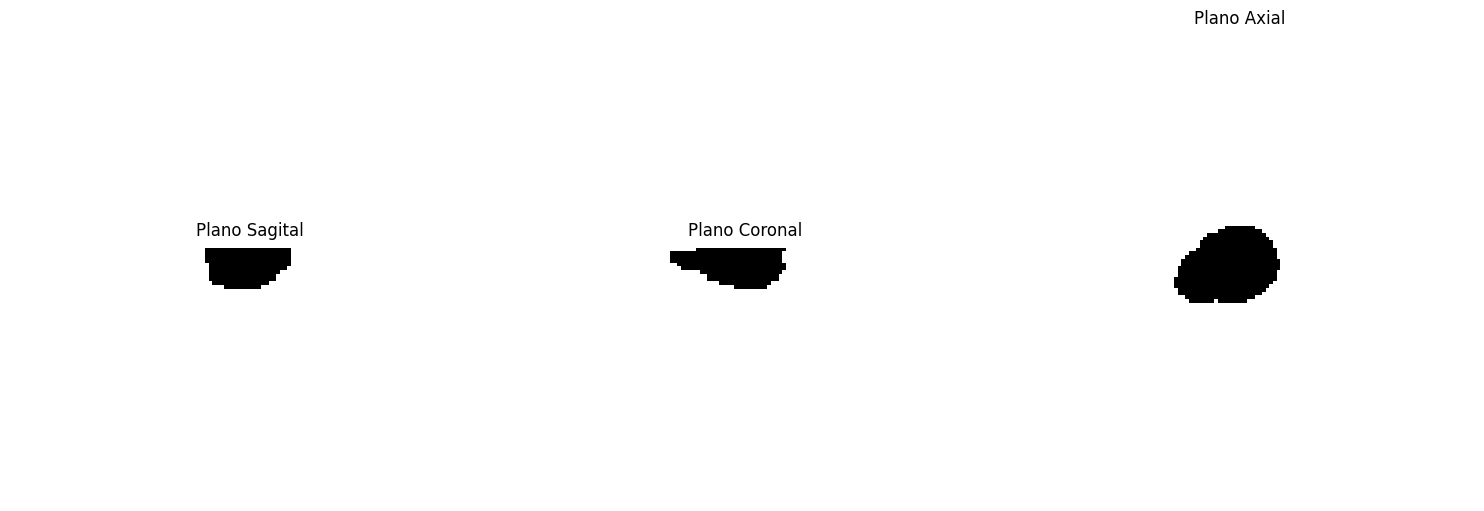

In [136]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Imagen de entrenamiento con ruido cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


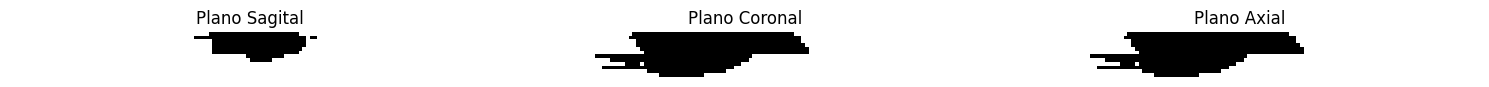

In [137]:
check_data_noise = next(iter(train_loader_noise))
image_tensor_noise = check_data_noise['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento con ruido cargada, tamaño: {image_tensor_noise.shape}")


width_idx = image_tensor_noise.size(4) // 2 # Sagittal
height_idx = image_tensor_noise.size(3) // 2 # Coronal
depth_idx = image_tensor_noise.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal_noise = image_tensor_noise[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal_noise.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal_noise = image_tensor_noise[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial_noise = image_tensor_noise[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

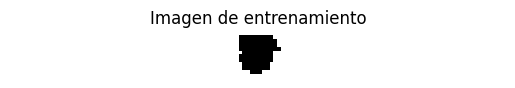

In [138]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 12, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


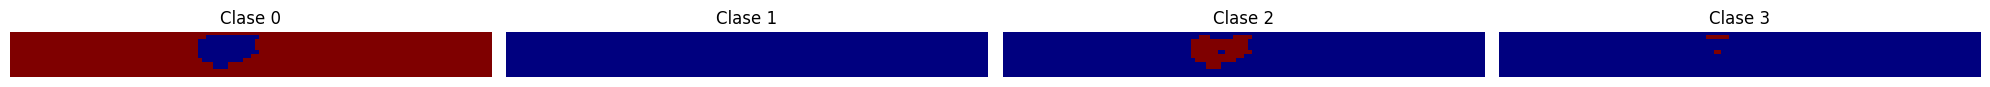

In [139]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


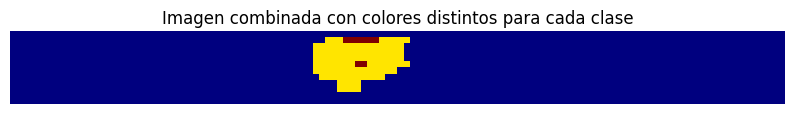

In [140]:
# slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [143]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=(1,2,2), padding=1), # [4, 12, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 6, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),      # [16, 12, 64, 64] -> [16, 12, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 12, 128, 128] -> [4, 12, 128, 128]
        )

    def forward(self, x):
        encoded = self.encoder(x) # [4, 12, 128, 128] -> [1, 3, 8, 8]
        latent_vector = self.fc(encoded.view(encoded.size(0), -1)) # [batch_size, 64]
        decoded = self.decoder(latent_vector.view(encoded.size()))
        return decoded, latent_vector
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 12, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [28]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

# Entrenamiento
num_epochs = 20
val_interval = 1
train_loss_list = []
val_loss_list = []
train_latent_vectors = []
val_latent_vectors = []

# Entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device)
        outputs, train_latent_vectors_output = model(inputs)
        
        train_latent_vectors.append(train_latent_vectors_output.detach().cpu().numpy()) 
        
        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_outputs, val_latent_vectors_output = model(val_inputs)
                
                val_latent_vectors.append(val_latent_vectors_output.detach().cpu().numpy())
                
                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 15.76it/s]


Epoch [1/20], Train Loss: 0.1541
Epoch [1/20], Validation Loss: 0.1079


100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [2/20], Train Loss: 0.0876
Epoch [2/20], Validation Loss: 0.1002


100%|██████████| 200/200 [00:11<00:00, 17.19it/s]


Epoch [3/20], Train Loss: 0.0773
Epoch [3/20], Validation Loss: 0.0937


100%|██████████| 200/200 [00:11<00:00, 16.93it/s]


Epoch [4/20], Train Loss: 0.0692
Epoch [4/20], Validation Loss: 0.0805


100%|██████████| 200/200 [00:11<00:00, 17.14it/s]


Epoch [5/20], Train Loss: 0.0663
Epoch [5/20], Validation Loss: 0.0883


100%|██████████| 200/200 [00:11<00:00, 17.17it/s]


Epoch [6/20], Train Loss: 0.0643
Epoch [6/20], Validation Loss: 0.0962


100%|██████████| 200/200 [00:11<00:00, 17.04it/s]


Epoch [7/20], Train Loss: 0.0605
Epoch [7/20], Validation Loss: 0.0802


100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


Epoch [8/20], Train Loss: 0.0577
Epoch [8/20], Validation Loss: 0.1290


100%|██████████| 200/200 [00:11<00:00, 17.20it/s]


Epoch [9/20], Train Loss: 0.0546
Epoch [9/20], Validation Loss: 0.0687


100%|██████████| 200/200 [00:11<00:00, 17.07it/s]


Epoch [10/20], Train Loss: 0.0499
Epoch [10/20], Validation Loss: 0.1557


100%|██████████| 200/200 [00:11<00:00, 17.30it/s]


Epoch [11/20], Train Loss: 0.0470
Epoch [11/20], Validation Loss: 0.0876


100%|██████████| 200/200 [00:11<00:00, 17.27it/s]


Epoch [12/20], Train Loss: 0.0472
Epoch [12/20], Validation Loss: 0.0683


100%|██████████| 200/200 [00:10<00:00, 18.21it/s]


Epoch [13/20], Train Loss: 0.0458
Epoch [13/20], Validation Loss: 0.0789


100%|██████████| 200/200 [00:11<00:00, 17.28it/s]


Epoch [14/20], Train Loss: 0.0463
Epoch [14/20], Validation Loss: 0.1173


100%|██████████| 200/200 [00:11<00:00, 17.09it/s]


Epoch [15/20], Train Loss: 0.0411
Epoch [15/20], Validation Loss: 0.0646


100%|██████████| 200/200 [00:11<00:00, 17.06it/s]


Epoch [16/20], Train Loss: 0.0408
Epoch [16/20], Validation Loss: 0.1128


100%|██████████| 200/200 [00:11<00:00, 17.26it/s]


Epoch [17/20], Train Loss: 0.0396
Epoch [17/20], Validation Loss: 0.0750


100%|██████████| 200/200 [00:11<00:00, 18.14it/s]


Epoch [18/20], Train Loss: 0.0412
Epoch [18/20], Validation Loss: 0.0661


100%|██████████| 200/200 [00:11<00:00, 17.00it/s]


Epoch [19/20], Train Loss: 0.0405
Epoch [19/20], Validation Loss: 0.0749


100%|██████████| 200/200 [00:11<00:00, 17.04it/s]


Epoch [20/20], Train Loss: 0.0383
Epoch [20/20], Validation Loss: 0.1041


In [144]:
model_noise = Autoencoder().to(device)
optimizer_noise = optim.Adam(model_noise.parameters(), lr=0.001, weight_decay=5e-6)
criterion_noise = nn.CrossEntropyLoss()

num_epochs_noise = 20
val_interval_noise = 1
train_loss_list_noise = []
val_loss_list_noise = []
train_latent_vectors_noise = []
val_latent_vectors_noise = []

# Entrenamiento
for epoch in range(num_epochs_noise):
    model_noise.train()
    train_loss_noise = 0
    
    for batch_data in tqdm(train_loader_noise):
        inputs_noise = batch_data["image"].to(device)
        outputs_noise, train_latent_vectors_output_noise = model_noise(inputs_noise)
        
        train_latent_vectors_noise.append(train_latent_vectors_output_noise.detach().cpu().numpy()) 
        
        loss_noise = criterion_noise(outputs_noise, F.interpolate(inputs_noise, size=outputs_noise.shape[2:], mode='nearest'))
        
        optimizer_noise.zero_grad()
        loss_noise.backward()
        optimizer_noise.step()
        train_loss_noise += loss_noise.item()

    avg_train_loss_noise = train_loss_noise / len(train_loader_noise)
    train_loss_list_noise.append(avg_train_loss_noise)
    print(f'Epoch [{epoch+1}/{num_epochs_noise}], Train Loss: {avg_train_loss_noise:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval_noise == 0:
        model_noise.eval()
        val_loss_noise = 0
        with torch.no_grad():
            for val_data_noise in val_loader_noise:
                val_inputs_noise = val_data_noise["image"].to(device)
                val_outputs_noise, val_latent_vectors_output_noise = model_noise(val_inputs_noise)
                
                val_latent_vectors_noise.append(val_latent_vectors_output_noise.detach().cpu().numpy())
                
                val_loss_noise += criterion_noise(val_outputs_noise, F.interpolate(val_inputs_noise, size=val_outputs_noise.shape[2:], mode='nearest')).item()
        
        avg_val_loss_noise = val_loss_noise / len(val_loader_noise)
        val_loss_list_noise.append(avg_val_loss_noise)
        print(f'Epoch [{epoch+1}/{num_epochs_noise}], Validation Loss: {avg_val_loss_noise:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:12<00:00, 16.03it/s]


Epoch [1/20], Train Loss: 0.1464
Epoch [1/20], Validation Loss: 0.1386


100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


Epoch [2/20], Train Loss: 0.0944
Epoch [2/20], Validation Loss: 0.1252


100%|██████████| 200/200 [00:12<00:00, 15.54it/s]


Epoch [3/20], Train Loss: 0.0870
Epoch [3/20], Validation Loss: 0.1150


100%|██████████| 200/200 [00:11<00:00, 16.78it/s]


Epoch [4/20], Train Loss: 0.0832
Epoch [4/20], Validation Loss: 0.1072


100%|██████████| 200/200 [00:11<00:00, 17.37it/s]


Epoch [5/20], Train Loss: 0.0794
Epoch [5/20], Validation Loss: 0.1022


100%|██████████| 200/200 [00:12<00:00, 16.20it/s]


Epoch [6/20], Train Loss: 0.0782
Epoch [6/20], Validation Loss: 0.0979


100%|██████████| 200/200 [00:11<00:00, 16.73it/s]


Epoch [7/20], Train Loss: 0.0719
Epoch [7/20], Validation Loss: 0.1030


100%|██████████| 200/200 [00:12<00:00, 16.47it/s]


Epoch [8/20], Train Loss: 0.0667
Epoch [8/20], Validation Loss: 0.1132


100%|██████████| 200/200 [00:11<00:00, 16.82it/s]


Epoch [9/20], Train Loss: 0.0652
Epoch [9/20], Validation Loss: 0.1129


100%|██████████| 200/200 [00:12<00:00, 16.37it/s]


Epoch [10/20], Train Loss: 0.0627
Epoch [10/20], Validation Loss: 0.1252


100%|██████████| 200/200 [00:11<00:00, 17.12it/s]


Epoch [11/20], Train Loss: 0.0621
Epoch [11/20], Validation Loss: 0.1039


100%|██████████| 200/200 [00:11<00:00, 16.97it/s]


Epoch [12/20], Train Loss: 0.0614
Epoch [12/20], Validation Loss: 0.1477


100%|██████████| 200/200 [00:12<00:00, 16.29it/s]


Epoch [13/20], Train Loss: 0.0610
Epoch [13/20], Validation Loss: 0.1035


100%|██████████| 200/200 [00:11<00:00, 16.99it/s]


Epoch [14/20], Train Loss: 0.0599
Epoch [14/20], Validation Loss: 0.1156


100%|██████████| 200/200 [00:12<00:00, 16.66it/s]


Epoch [15/20], Train Loss: 0.0603
Epoch [15/20], Validation Loss: 0.1050


100%|██████████| 200/200 [00:12<00:00, 16.33it/s]


Epoch [16/20], Train Loss: 0.0583
Epoch [16/20], Validation Loss: 0.1027


100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


Epoch [17/20], Train Loss: 0.0581
Epoch [17/20], Validation Loss: 0.1218


100%|██████████| 200/200 [00:12<00:00, 16.59it/s]


Epoch [18/20], Train Loss: 0.0568
Epoch [18/20], Validation Loss: 0.1161


100%|██████████| 200/200 [00:12<00:00, 16.54it/s]


Epoch [19/20], Train Loss: 0.0571
Epoch [19/20], Validation Loss: 0.1348


100%|██████████| 200/200 [00:12<00:00, 16.39it/s]


Epoch [20/20], Train Loss: 0.0559
Epoch [20/20], Validation Loss: 0.1202


In [ ]:
train_latent_vectors_array = np.concatenate(train_latent_vectors, axis=0)
val_latent_vectors_array = np.concatenate(val_latent_vectors, axis=0)
train_latent_vectors_array_noise = np.concatenate(train_latent_vectors_noise, axis=0)
val_latent_vectors_array_noise = np.concatenate(val_latent_vectors_noise, axis=0)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors.tsv'), train_latent_vectors_array, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors.tsv'), val_latent_vectors_array, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_noise.tsv'), train_latent_vectors_array_noise, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_noise.tsv'), val_latent_vectors_array_noise, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")
print(f"Vectores latentes guardados en {output_dir}")

Vectores latentes guardados en /mnt/nfs/home/liglesias


In [ ]:
import pandas as pd

output_dir = '/mnt/nfs/home/liglesias'
val_latent_vectors_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors.tsv'), sep='\t', header=None)
val_latent_vectors_noise_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_noise.tsv'), sep='\t', header=None)

if val_latent_vectors_df.shape[1] != val_latent_vectors_noise_df.shape[1]:
    raise ValueError("Vector dimensions do not match")

combined_df = pd.concat([val_latent_vectors_df, val_latent_vectors_noise_df], ignore_index=True)

num_original = len(val_latent_vectors_df)
num_noise = len(val_latent_vectors_noise_df)

metadata = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Noise'] * num_noise
}
metadata_df = pd.DataFrame(metadata)
combined_df.to_csv(os.path.join(output_dir, 'combined_val_latent_vectors.tsv'), sep='\t', index=False, header=False)
metadata_df.to_csv(os.path.join(output_dir, 'metadata.tsv'), sep='\t', index=False)

print(f"Vectores latentes combinados guardados en {output_dir}/combined_val_latent_vectors.tsv")
print(f"Archivo de metadatos guardado en {output_dir}/metadata.tsv")

Vectores latentes combinados guardados en /mnt/nfs/home/liglesias/combined_val_latent_vectors.tsv
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata.tsv


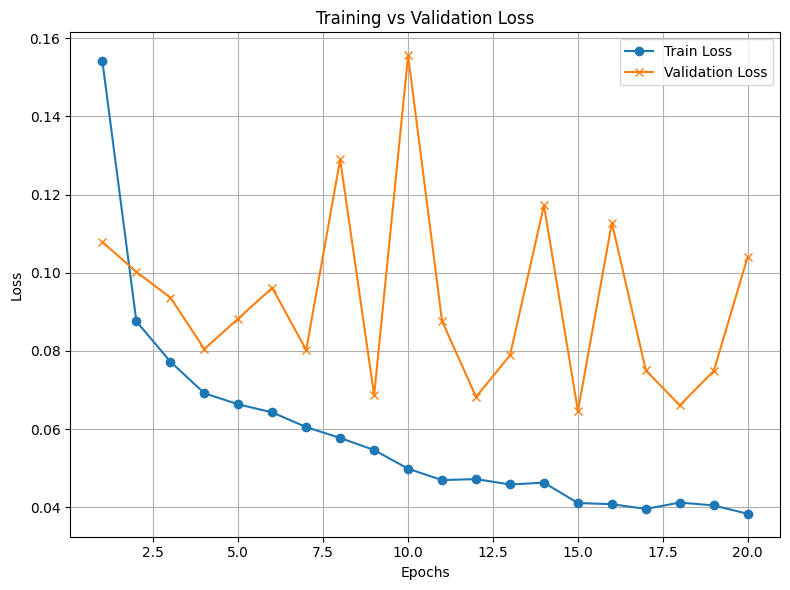

In [30]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

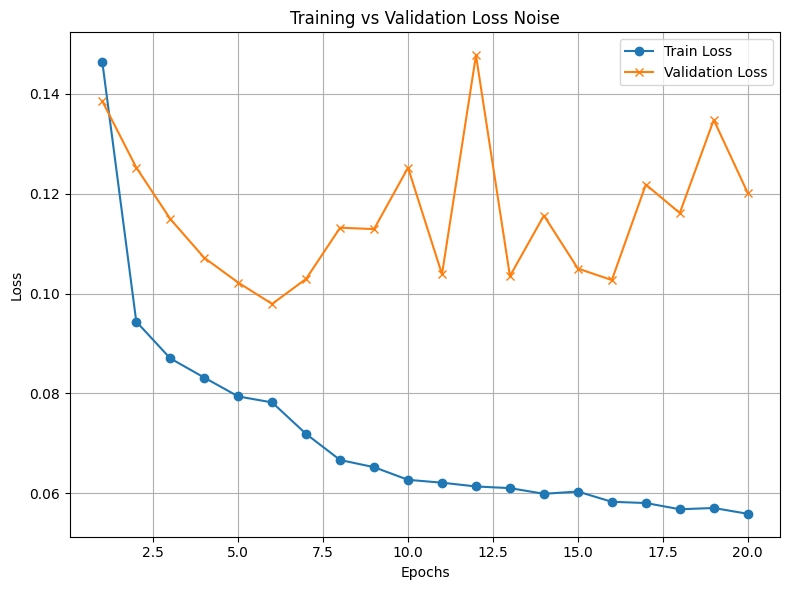

In [145]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs_noise + 1), train_loss_list_noise, label="Train Loss", marker='o')
val_epochs_noise = list(range(val_interval_noise, num_epochs_noise + 1, val_interval_noise))
plt.plot(val_epochs_noise, val_loss_list_noise, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [146]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2  # Índice de la rebanada central
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])


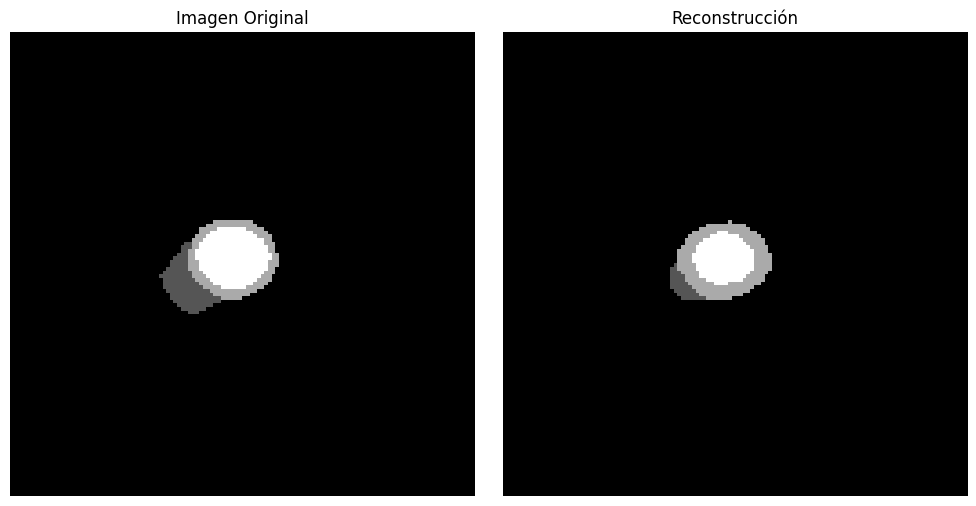

In [33]:
visualize_axial_reconstruction(model, val_loader, device)

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])


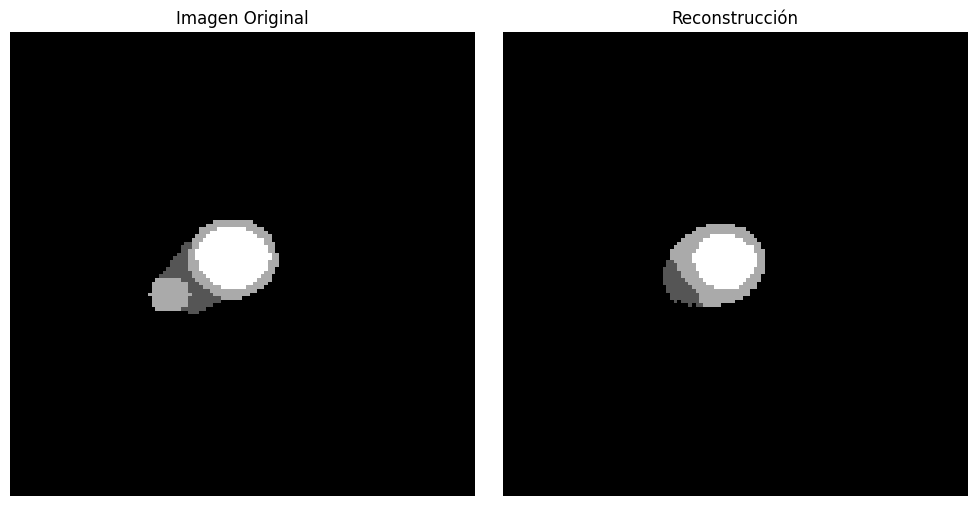

In [147]:
visualize_axial_reconstruction(model_noise, val_loader_noise, device)

In [148]:
print("Latent Vectors from Training:")
print(len(train_latent_vectors))
print(train_latent_vectors[0].shape)
#print(train_latent_vectors)  
print("Latent Vectors from Validation:")
print(len(val_latent_vectors))
print(val_latent_vectors[0].shape)
#print(val_latent_vectors)

Latent Vectors from Training:
4000
(1, 192)
Latent Vectors from Validation:
2000
(1, 192)


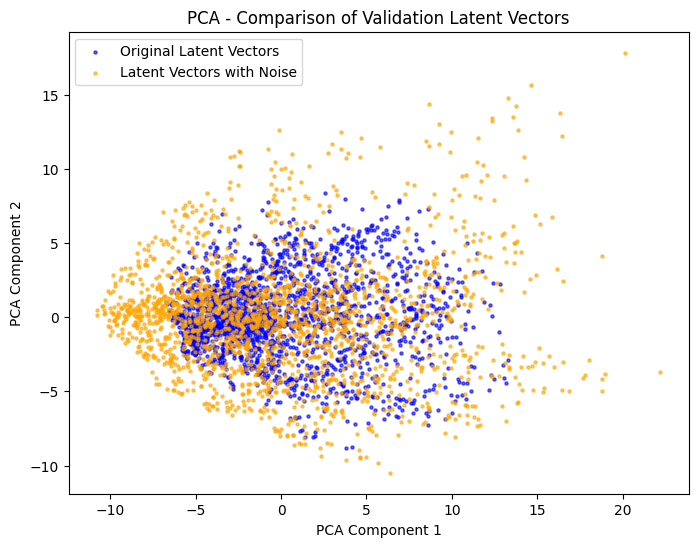

In [149]:
from sklearn.decomposition import PCA

val_latent_vectors_array = np.concatenate(val_latent_vectors, axis=0)
val_latent_vectors_array_noise = np.concatenate(val_latent_vectors_noise, axis=0)

pca = PCA(n_components=2)
val_latent_vectors_pca = pca.fit_transform(val_latent_vectors_array)
val_latent_vectors_pca_noise = pca.fit_transform(val_latent_vectors_array_noise)

plt.figure(figsize=(8, 6))
plt.scatter(val_latent_vectors_pca[:, 0], val_latent_vectors_pca[:, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(val_latent_vectors_pca_noise[:, 0], val_latent_vectors_pca_noise[:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

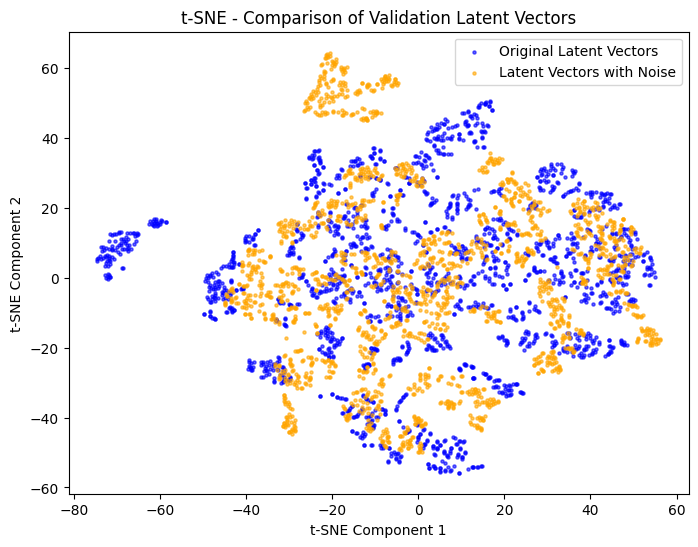

In [150]:
# Usando t-sne en lugar de PCA

from sklearn.manifold import TSNE

# Supongamos que val_latent_vectors y val_latent_vectors_noise ya están definidos
val_latent_vectors_array = np.concatenate(val_latent_vectors, axis=0)
val_latent_vectors_array_noise = np.concatenate(val_latent_vectors_noise, axis=0)

# Usar t-SNE para la reducción de dimensionalidad
tsne = TSNE(n_components=2, random_state=42)
val_latent_vectors_tsne = tsne.fit_transform(val_latent_vectors_array)
val_latent_vectors_tsne_noise = tsne.fit_transform(val_latent_vectors_array_noise)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(val_latent_vectors_tsne[:, 0], val_latent_vectors_tsne[:, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(val_latent_vectors_tsne_noise[:, 0], val_latent_vectors_tsne_noise[:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


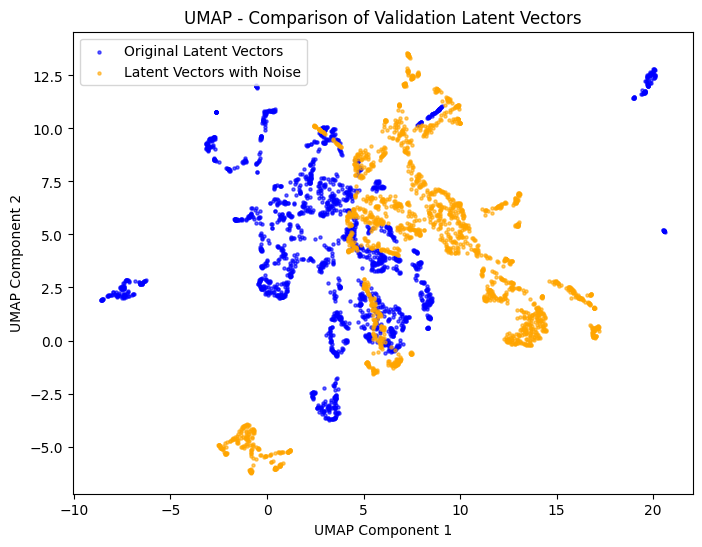

In [ ]:
# Usando UMAP

import umap

# Supongamos que val_latent_vectors y val_latent_vectors_noise ya están definidos
val_latent_vectors_array = np.concatenate(val_latent_vectors, axis=0)
val_latent_vectors_array_noise = np.concatenate(val_latent_vectors_noise, axis=0)

# Usar UMAP para la reducción de dimensionalidad
umap_reducer = umap.UMAP(n_components=2, random_state=42)
val_latent_vectors_umap = umap_reducer.fit_transform(val_latent_vectors_array)
val_latent_vectors_umap_noise = umap_reducer.fit_transform(val_latent_vectors_array_noise)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(val_latent_vectors_umap[:, 0], val_latent_vectors_umap[:, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(val_latent_vectors_umap_noise[:, 0], val_latent_vectors_umap_noise[:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()
